# Recitation 9: variance reduction

* When the antithetic method fails
* Contorl variates
* Importance sampling

Picture of the blackbaord after the recitation.

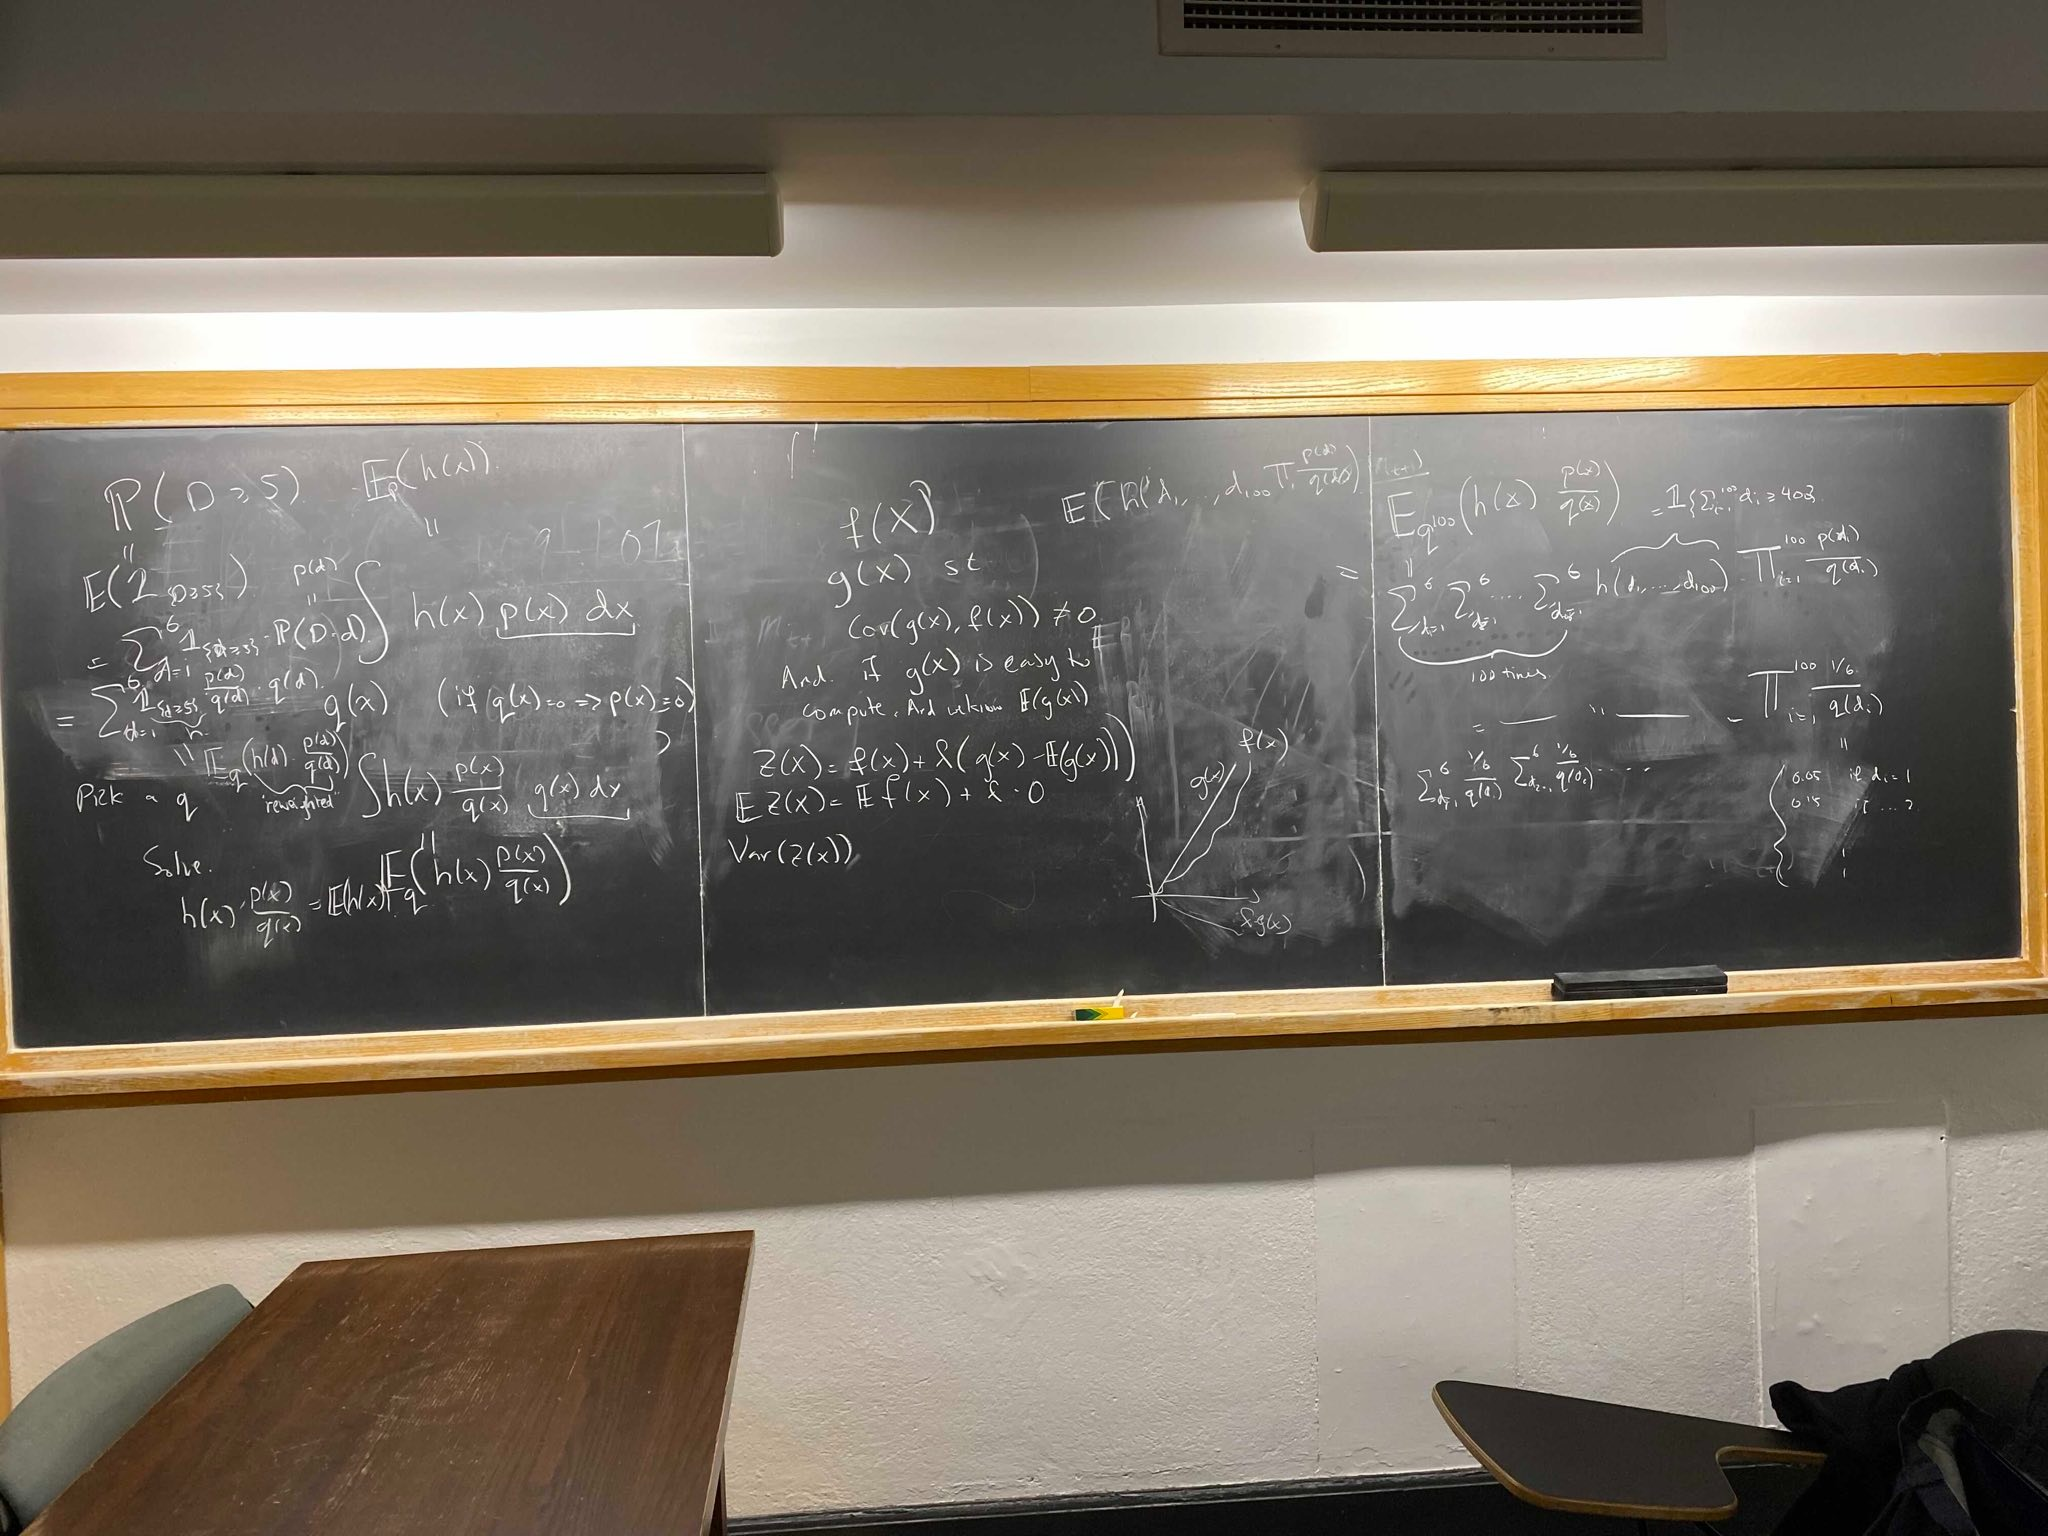

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Example where the naïve antithetic method fails

Suppose you want to compute $\mathbb{E}(f(x))$ where $f(x)=(x-1/2)^2$, $x\in[0,1]$.

This is easy with MC integration:

In [2]:
def f(x):
    return (x-1/2)**2

True mean is about 0.08335000166683335


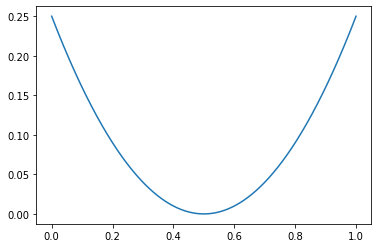

In [3]:
xs = np.linspace(0,1,10_000)
plt.plot(xs, (xs-1/2)**2)
true_mean = (f(xs)).mean()
print(f"True mean is about {true_mean}")

In [4]:
n = 40
reps = 100_000

In [5]:
means1 = []
for _ in range(reps):
    us = np.random.uniform(size=(n))
    means1.append(np.mean(f(us)))

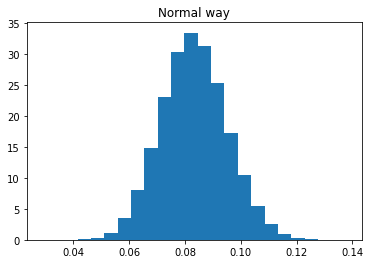

In [6]:
plt.hist(means1, density=True, bins=21)
plt.xlim((true_mean - 0.06, true_mean + 0.06))
plt.title("Normal way");

In [7]:
means2 = []
for _ in range(reps):
    us = np.random.uniform(size=(n//2))
    y = (f(us) + f(1-us))/2
    means2.append(np.mean(y))

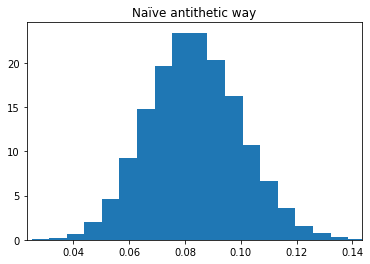

In [8]:
plt.hist(means2, density=True, bins=21)
plt.xlim((true_mean - 0.06, true_mean + 0.06))
plt.title("Naïve antithetic way");

In [9]:
means3 = []
for _ in range(reps):
    us = np.random.uniform(size=(n//2))
    y = (f(us) + f((us+0.5)%1))/2
    means3.append(np.mean(y))

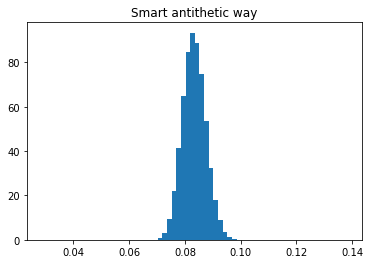

In [10]:
plt.hist(means3, density=True, bins=21)
plt.xlim((true_mean - 0.06, true_mean + 0.06))
plt.title("Smart antithetic way");

## Control variate example

Let's try to compute $\int_0^1\exp(x)\,dx=\mathbb{E}(\exp(U))=e-1$ using $U$ as a control variate.

Recall that using this technique, instead of estimating $\mathbb{E}(\exp(U))$, we estimate $\mathbb{E}(\exp(U)+\lambda(U-1/2))$ for some $\lambda$. The optimal one is given by $\lambda=-\sigma_{fg}/\sigma_g^2$.

We know $\sigma_g^2=1/12$, so let's estimate $\sigma_{fg}=\mbox{Cov}(\exp(U),U)$:

Take $g(U)=U$, so $g(x)=x$. Then $\mathbb{E}(g(U))=1/2$, $\mbox{Var}(g(U))=1/12$.

In [11]:
us = np.random.uniform(size=100)
cov_matrix = np.cov(np.exp(us), us, ddof=1)
cov_matrix

array([[0.26091235, 0.15110701],
       [0.15110701, 0.08885384]])

In [12]:
sigma_fg = cov_matrix[0,1]
sigma_fg

0.15110701125496417

In [13]:
sigma_g2 = 1/12

In [14]:
lmbda = -sigma_fg / sigma_g2

In [15]:
lmbda

-1.81328413505957

In [16]:
us = np.random.uniform(size=1000)
naive = np.var(np.exp(us), ddof=1)

In [17]:
us = np.random.uniform(size=1000)
Z = np.exp(us) + lmbda * (us-1/2)
Zvar = np.var(Z, ddof=1)

In [18]:
np.mean(Z)

1.7219706932055405

In [19]:
np.exp(1)-1

1.718281828459045

In [20]:
naive

0.2485689726049349

In [21]:
Zvar

0.0052150161366984185

In [22]:
1 - Zvar / naive

0.9790198427340047

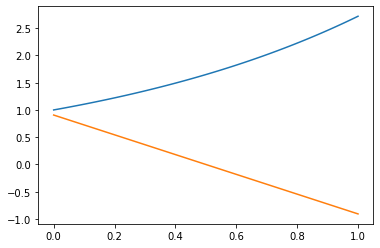

In [23]:
xs = np.linspace(0,1,100)
plt.plot(xs, np.exp(xs))
plt.plot(xs, lmbda*(xs-1/2))

## Importance sampling

Suppose you go to the casino in Monte Carlo, and they have the following stupid game;

* You roll 100 dice
* If the sum exceeds 400, you win and make $10k
* Otherwise you lose and are presumably sad you wasted your money

How much should you pay to play this game if you are maximizing expected profit?

Let's start off trying to do importance sampling for $\mathbb{P}(D\geq 5)$ where $D$ is a random dice roll.

In [24]:
q = np.array([0.05, 0.1, 0.15, 0.2, 0.25, 0.25])

$p(d)=1/6$.

In [25]:
(np.arange(1, 7) >= 5) * (1/6) / q

array([0.        , 0.        , 0.        , 0.        , 0.66666667,
       0.66666667])

In [26]:
def importance_sampler(size):
    reweighted = (np.arange(1, 7) >= 5) * (1/6) / q
    return np.random.choice(reweighted, p=q, size=size)

In [27]:
np.var(np.random.choice(np.arange(1, 7), size=1000) >= 5)

0.221776

In [28]:
np.var(importance_sampler(size=1000))

0.11109999999999999

Back to the original problem:

In [29]:
def compute_integrand(biased_rolls):
    return (np.sum(biased_rolls) >= 400) * np.prod([(1/6)/q[roll-1] for roll in biased_rolls])

In [30]:
biased_rolls_samples = np.random.choice(np.arange(1, 7), p=q, size=(100, 1_000))
outcomes = np.apply_along_axis(compute_integrand, 0, biased_rolls_samples)
np.mean(10_000*outcomes)

15.731194912582241

In [31]:
10_000*np.mean(np.sum(np.random.randint(1,7,size=(100,10000)), axis=0) >= 400)

22.0

In [32]:
out_orig = []
for _ in range(100):
    out_orig.append(10_000*np.mean(np.sum(np.random.randint(1,7,size=(100,1_000)), axis=0) >= 400))

In [33]:
out_importance_sampling = []
for _ in range(100):
    biased_rolls_samples = np.random.choice(np.arange(1, 7), p=q, size=(100, 1_000))
    outcomes = np.apply_along_axis(compute_integrand, 0, biased_rolls_samples)
    out_importance_sampling.append(10_000*np.mean(outcomes))

In [34]:
np.var(out_orig)

183.44000000000003

In [35]:
np.var(out_importance_sampling)

37.1163622430331

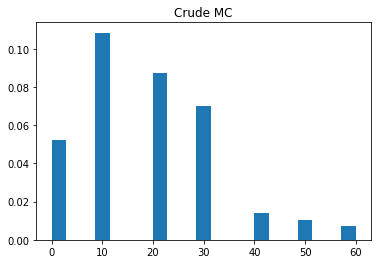

In [36]:
plt.hist(out_orig, density=True, bins=21)
plt.title("Crude MC");

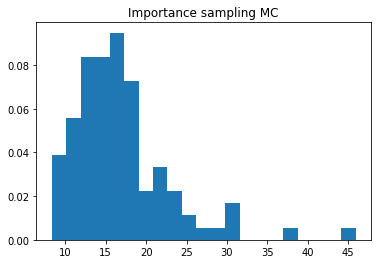

In [37]:
plt.hist(out_importance_sampling, density=True, bins=21)
plt.title("Importance sampling MC");